In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 10 14:07:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [3]:
!pip install ipython-autotime
%load_ext autotime

time: 219 µs (started: 2022-02-10 14:07:47 +00:00)


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 9.66 ms (started: 2022-02-10 14:07:47 +00:00)


In [5]:
!pip install --quiet optuna

     |████████████████████████████████| 308 kB 9.6 MB/s 
     |████████████████████████████████| 80 kB 11.4 MB/s 
     |████████████████████████████████| 210 kB 65.4 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 149 kB 71.0 MB/s 
     |████████████████████████████████| 113 kB 56.8 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
time: 7.85 s (started: 2022-02-10 14:07:47 +00:00)


In [6]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 4.26 s (started: 2022-02-10 14:07:55 +00:00)


# Variables

## Paths

In [7]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220210_14H07/
time: 279 ms (started: 2022-02-10 14:07:59 +00:00)


## Other

In [10]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000  # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

time: 3.83 ms (started: 2022-02-10 14:09:02 +00:00)


# Load & filter data

## Unzip images

In [ ]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

In [12]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.47 ms (started: 2022-02-10 14:11:16 +00:00)


## File_path df

In [13]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 4.39 s (started: 2022-02-10 14:11:16 +00:00)


In [14]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 4 ms (started: 2022-02-10 14:11:21 +00:00)


In [15]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 259 ms (started: 2022-02-10 14:11:21 +00:00)


In [16]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 189 ms (started: 2022-02-10 14:11:21 +00:00)


In [17]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 49.8 ms (started: 2022-02-10 14:11:21 +00:00)


In [18]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 42 ms (started: 2022-02-10 14:11:21 +00:00)


In [19]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 74.8 ms (started: 2022-02-10 14:11:21 +00:00)


In [20]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 27.5 ms (started: 2022-02-10 14:11:21 +00:00)


In [21]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 32.8 ms (started: 2022-02-10 14:11:21 +00:00)


In [22]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 745 µs (started: 2022-02-10 14:11:21 +00:00)


In [23]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 86.2 ms (started: 2022-02-10 14:11:21 +00:00)


In [24]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.88 ms (started: 2022-02-10 14:11:21 +00:00)


In [25]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 32.2 ms (started: 2022-02-10 14:11:21 +00:00)


In [26]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 2.06 ms (started: 2022-02-10 14:11:22 +00:00)


In [27]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 21.9 ms (started: 2022-02-10 14:11:22 +00:00)


In [28]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 5.7 ms (started: 2022-02-10 14:11:22 +00:00)


## Train/test split

In [29]:
#train/test 
# Train/test
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
# train / val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
print(df_train_.shape,df_val_.shape,df_test.shape)

(3200, 3) (800, 3) (1000, 3)
time: 21.1 ms (started: 2022-02-10 14:11:22 +00:00)


In [30]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 6.71 ms (started: 2022-02-10 14:11:22 +00:00)


### Plot few images

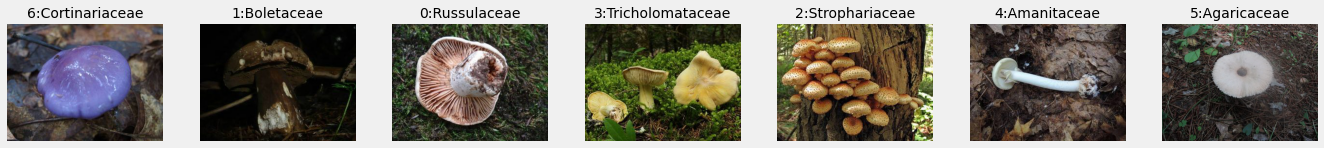

time: 602 ms (started: 2022-02-10 14:11:22 +00:00)


In [31]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

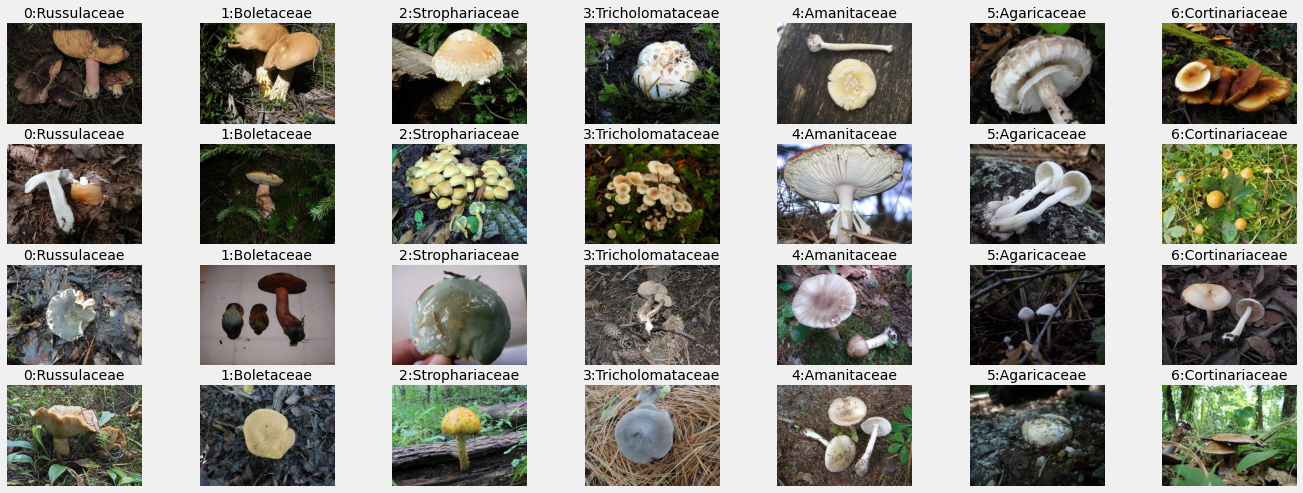

time: 1.61 s (started: 2022-02-10 14:11:22 +00:00)


In [32]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = im_per_class
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# LrFinder

In [33]:
# define base model  
model_name = 'EFB1'
base_model = tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False)
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
print(export_dir,'\n',pathinfos)

27033600/27018416 [==============================] - 1s 0us/step
/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220210_14H07/ 
 EFB1_(240, 320)_7families_4000_images
time: 5.85 s (started: 2022-02-10 14:11:24 +00:00)


In [34]:
epochs = 100

time: 664 µs (started: 2022-02-10 14:11:30 +00:00)


In [35]:
#  essai find best lr 
i = 0
model_metric = {}
model_number = 0
model_number_str =  '_model_#' + str(model_number) # for save figs paths
# Clear clutter from previous TensorFlow graphs.
tf.keras.backend.clear_session()
# define set of model params 
batch_size  = 16 # param_dict['batch_size']
layer_dropouts = (0.3,0.2)
# datagen 
# train 
train_data_generator = ImageDataGenerator(
                                          # rotation_range=0.1,horizontal_flip= True,vertical_flip= True
                                          ) 
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')
# val
val_data_generator = ImageDataGenerator() 
val_generator = val_data_generator.flow_from_dataframe(dataframe = df_val_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label", 
                                                        shuffle = False, # to match df_test order 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

# construct model 
# base + average 
layers = [base_model,tf.keras.layers.GlobalAveragePooling2D()] 
# prediction 
layers.append(Dense(units = classes_count, activation = 'softmax'))
# dense + dropout 
layers.append(tf.keras.layers.Dense(units = 1024, activation = 'relu'))
layers.append(tf.keras.layers.Dropout(layer_dropouts[0]))
layers.append(tf.keras.layers.Dense(units = 512, activation = 'relu')) 
layers.append(tf.keras.layers.Dropout(layer_dropouts[1]))
#freeze/unfreeze all layers 
for layer in base_model.layers:
    layer.trainable = False
#create model 
model = tf.keras.Sequential(layers,name = model_name)
model.summary()
# compilation 
optimizer =  'Adam'
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
# Entraînement
tic = time.time() # timer start
def schedule_func(epoch):
    print()
    print('calling lr_scheduler on epoch %i' % epoch)
    print('current learning rate %.8f' % K.eval(model.optimizer.lr))
    print('returned value %.8f' % (1e-8 * 10**(epoch / 20)))
    return 1e-8 * 10**(epoch / 20)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule_func)
training_history_model_1 = model.fit(train_generator,epochs=epochs,
                                steps_per_epoch = len(df_train_)//batch_size,
                                validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                  class_weight=class_weights,
                                callbacks=[
                            lr_schedule 
                                            ],
                                # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                ) 

Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
 dense_1 (Dense)             (None, 1024)              8192      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
            

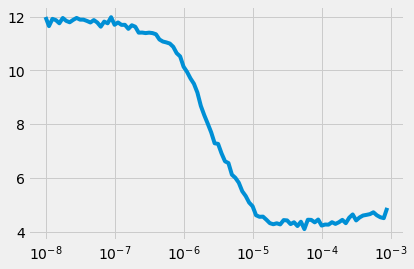

time: 584 ms (started: 2022-02-10 14:44:54 +00:00)


In [36]:
lrs = 1e-8 * (10**(np.arange(epochs)/20))
plt.semilogx(lrs,training_history_model_1 .history['loss'])

# Links

* https://www.jeremyjordan.me/nn-learning-rate/
* https://stackoverflow.com/questions/64673469/how-to-pick-the-best-learning-rate-and-optimizer-using-learningratescheduler
* https://tensorflow.backprop.fr/time-series-sequences-and-predictions/adjust-the-learning-rate-dynamically-in-time-series-sequence-and-prediction-models/
* chercher '1e-8 * 10**(epoch / 20)' sur google  
* https://www.analyticsvidhya.com/blog/2021/06/decide-best-learning-rate-with-learningratescheduler-in-tensorflow/